# Learning $\sin(t)$ with a Recurrent Neural Network

Import packages :

In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import tqdm

In this notebook we train a Recurrent Neural Network to predict the sequence given by $sin(t)$. More precisely, we want to reproduce the following sequence:

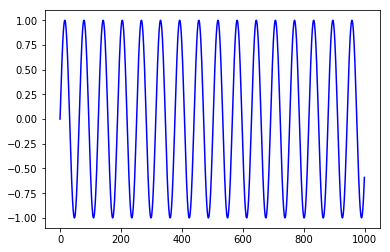

In [2]:
h = 0.1;
dataSin = np.sin(np.arange(0.0, 100.0, h));
plt.plot(dataSin, 'b')

## Pre-training

### Construct Data

We will cut the data in windows of <br>
$$partition = memory + offset$$

data points. The first $\mbox{memory}$ points is the input variable, and the last $\mbox{future}$ data points is the target variable: 

$$\{y_{i-memory},y_{i-(memory-1)},\cdots, y_{i-1}\}  \rightarrow \{ y_{(i + offset) - future}, y_{(i + offset) - (future-1)}, \cdots, y_{(i + offset) - 1} \}$$

We create the Dataset object to manage the data:

In [3]:
class SinDataset(Dataset):
    """ Sin(x) dataset."""
    
    def __init__(self, h_size, memory, future, offset):
        
        # Generate the sin sequence 
        data = torch.sin(torch.arange(0.0, 100.0, h_size))
        
        partition = memory + offset
        
        XY = torch.zeros(len(data) - partition, partition)
        
        self.len = XY.shape[0]
        
        for i in range(self.len):
            XY[i, :] = data[i:i + partition]
        
        self.x_data = XY[:,0:memory]
        self.y_data = XY[:,-future:]
                
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

### Design Model

We creeate a RNN with a readout layer:

In [4]:
class RNNModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first = True, nonlinearity = 'tanh')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        # h0.shape must be torch.Size([layer_dim, batch_size, hidden_dim])
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out) 
        return out

We define an initialization function:

In [5]:
# Initialitation
def init_weights(self):
    for m in self.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                print(f'Initialization of {name}', end="", flush=True)
                if 'weight_ih' in name:   
                    torch.nn.init.xavier_uniform_(param.data)
                    print('...done')
                elif 'weight_hh' in name:
                    torch.nn.init.orthogonal_(param.data)
                    print('...done')
                elif 'bias' in name:
                    param.data.fill_(0)
                    print('...done')

## Training

Setup the training process: Model + Loss + Optimizer

In [6]:
# Data parameters
h_size = 0.1
memory = 10
future = 10
offset = 1

# Global parameters
input_dim = 1      # input dimension
hidden_dim = 100   # hidden layer dimension
layer_dim = 1      # number of hidden layers
output_dim = 1     # output dimension

# Dataset
dataset = SinDataset(h_size, memory, future, offset)
# DataLoader
train_loader = DataLoader(dataset = dataset,
                          batch_size = 32,
                          shuffle = True,
                          num_workers = 1)

# Model
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Initialization                  
model.apply(init_weights)

# Criterion
criterion = nn.MSELoss()

# SGD Optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

Initialization of weight_ih_l0...done
Initialization of weight_hh_l0...done
Initialization of bias_ih_l0...done
Initialization of bias_hh_l0...done
Initialization of weight_ih_l0...done
Initialization of weight_hh_l0...done
Initialization of bias_ih_l0...done
Initialization of bias_hh_l0...done


* Create the training loop:

In [7]:
num_epochs = 2000

for epoch in range(num_epochs):
    
    for i, data in enumerate(train_loader, 0):
 
        # Get the inputs
        XX, yy = data

        # X.shape = torch.Size([32, 7])
        # y.shape = torch.Size([32, 7])
        # We need to reshape these vectors to be torch.Size([32, 7, 1]) 
        X = XX.view(-1, memory, input_dim)
        y = yy.view(-1, memory, input_dim)

        # Train step
        model.train()
        optimizer.zero_grad()

        y_ = model(X)
        loss = criterion(y_, y)

        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            if i % 16 == 0:        
                # Evaluation
                model.eval()
                with torch.no_grad():
                    y_ = model(X)

                # Compute and print loss
                loss = criterion(y_, y)
                
                print(f'Epoch : {epoch}, Iteration : {i}, Loss : {loss.item()}')

Epoch : 0, Iteration : 0, Loss : 0.5374462604522705
Epoch : 0, Iteration : 16, Loss : 0.37935641407966614
Epoch : 100, Iteration : 0, Loss : 0.0024729897268116474
Epoch : 100, Iteration : 16, Loss : 0.0029909599106758833
Epoch : 200, Iteration : 0, Loss : 0.0014466274296864867
Epoch : 200, Iteration : 16, Loss : 0.0018831908237189054
Epoch : 300, Iteration : 0, Loss : 0.0015678678173571825
Epoch : 300, Iteration : 16, Loss : 0.0015264294343069196
Epoch : 400, Iteration : 0, Loss : 0.0011452153557911515
Epoch : 400, Iteration : 16, Loss : 0.001251565758138895
Epoch : 500, Iteration : 0, Loss : 0.001373835257254541
Epoch : 500, Iteration : 16, Loss : 0.0007251922506839037
Epoch : 600, Iteration : 0, Loss : 0.0012293691979721189
Epoch : 600, Iteration : 16, Loss : 0.000799933448433876
Epoch : 700, Iteration : 0, Loss : 0.0010628270683810115
Epoch : 700, Iteration : 16, Loss : 0.0011148450430482626
Epoch : 800, Iteration : 0, Loss : 0.0009172290447168052
Epoch : 800, Iteration : 16, Loss :

## Post-processing

* Investigate the result

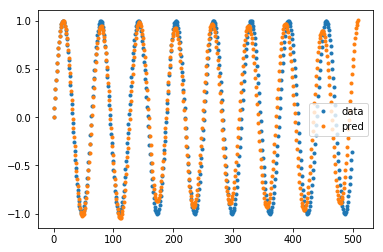

In [11]:
# Visualization
with torch.no_grad():
    
    # Starting sequence
    h = 0.1;
    dataSin = torch.sin(torch.arange(0.0, 50.0, h))
    
    # Initial sequence
    seq = dataSin[0:memory]
   
    # Predicted list of values
    dataSin_pred = seq[:].numpy().tolist()
    
    
    # Model in evaluation state
    model.eval()      
    
    for i in range(500):
        
        seq = seq.view(-1, memory, input_dim)
        
        # Evalaute the model
        y_ = model(seq)
          
        # Create the next sequence of seq_dim lenght to be avaluated by the model
        seq = torch.cat((seq[:,offset:,:], y_[:,-offset:,:].view(-1, offset, 1)), 1)    

    
        # Append to the predicted list
        dataSin_pred = dataSin_pred + y_[0,-offset:,0].numpy().tolist()
        
    
    fig, ax = plt.subplots()
    ax.plot(dataSin.numpy(),".", label="data")
    ax.plot(dataSin_pred, ".", label="pred")
    ax.legend();